In [137]:
#Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


import pickle

In [7]:
#Load the data
df=pd.read_csv('heart.csv')


In [13]:
#data head
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [15]:
#data tail
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [18]:
#data dimensions
df.shape

(303, 14)

In [20]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [22]:
#checking for missing values
df.isnull().sum()

#No any missing values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [30]:
#checking for duplicates
df.duplicated().sum()


1

In [32]:
#removing duplicates
df.drop_duplicates(inplace = True)

In [52]:
#Data analysis
df.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [73]:
#Data columns
col=df.columns
col

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

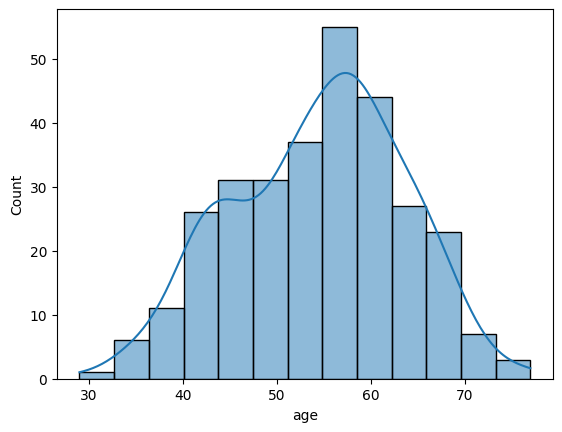

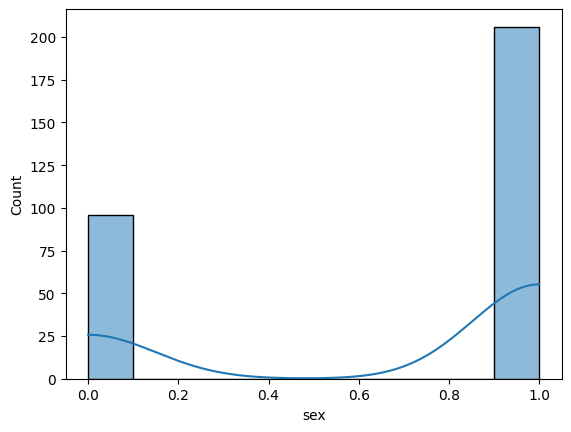

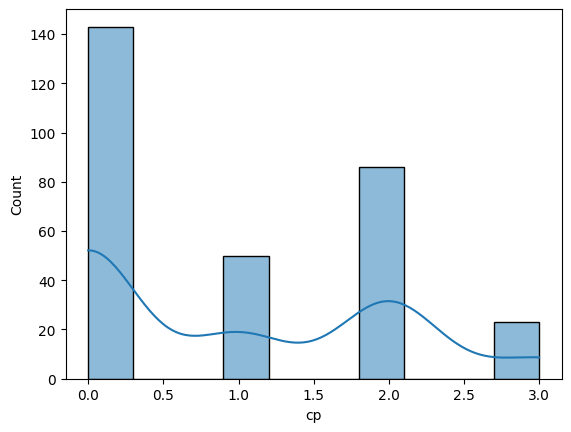

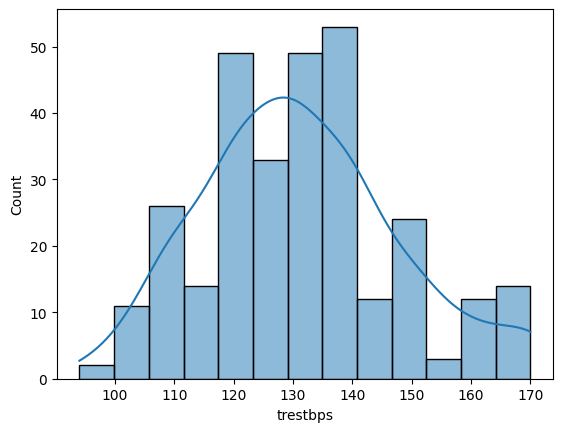

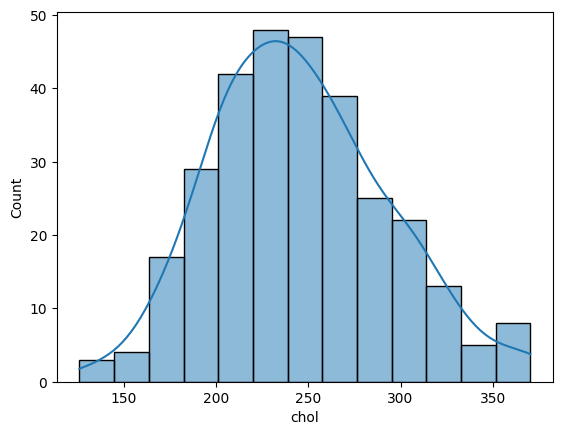

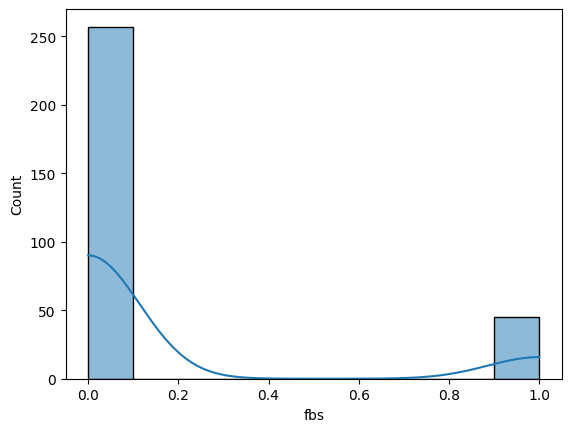

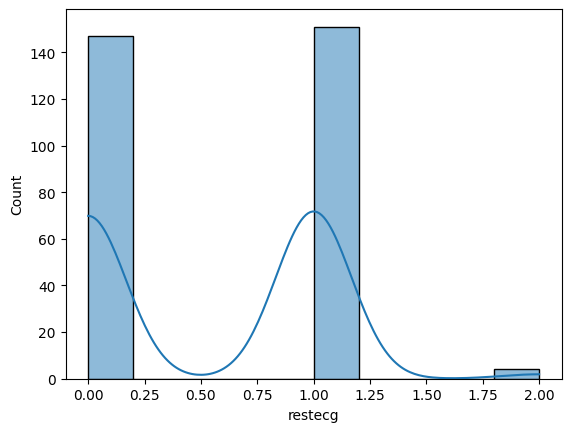

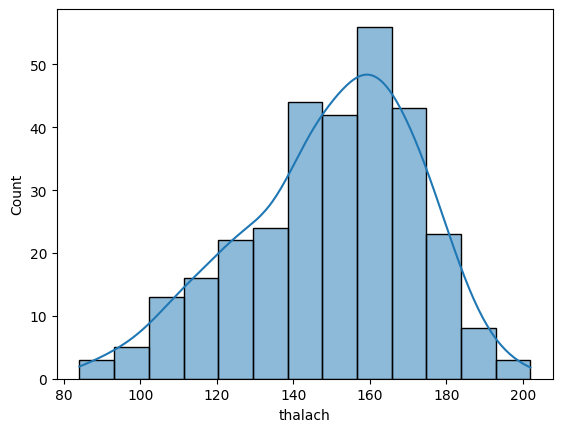

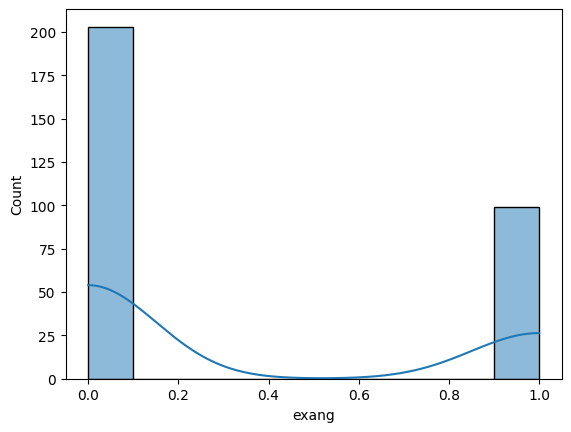

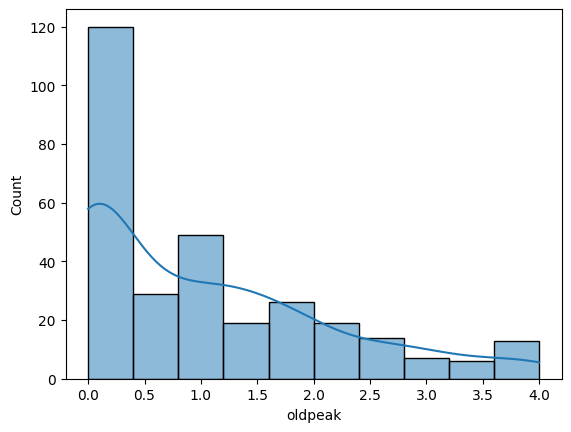

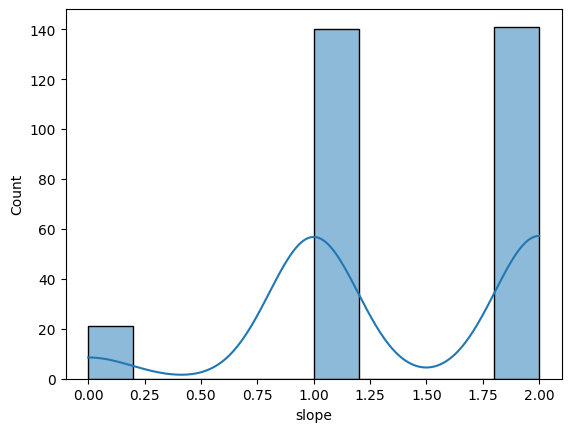

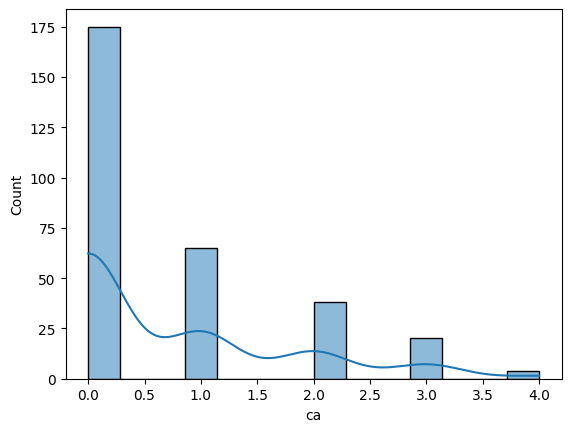

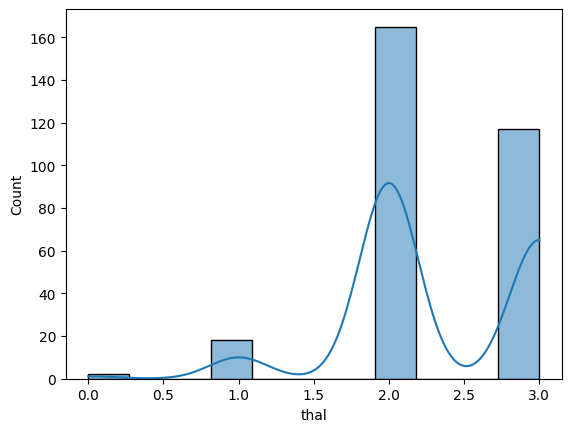

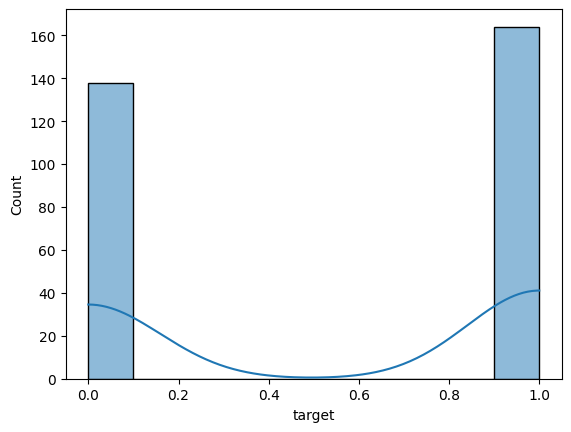

In [93]:
#Understanding the distribution through histograms
for i in col:
    sns.histplot(data = df,x=i,kde=True)
    plt.show()

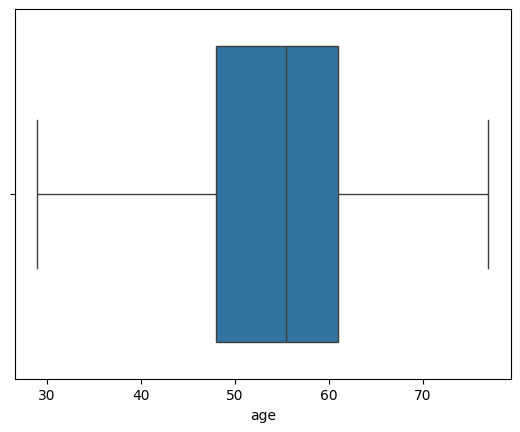

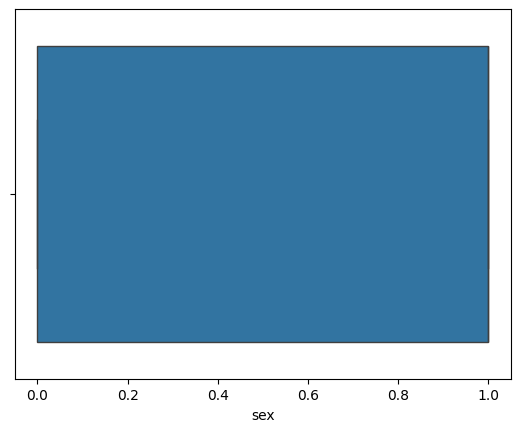

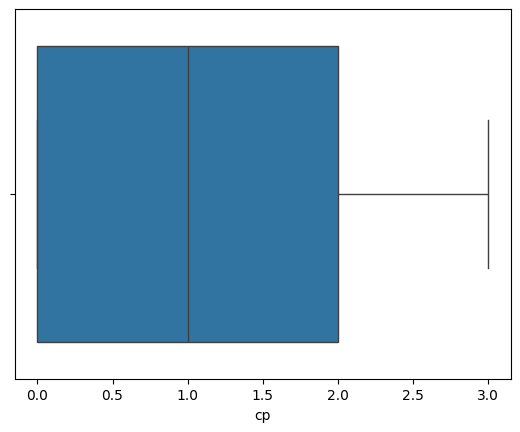

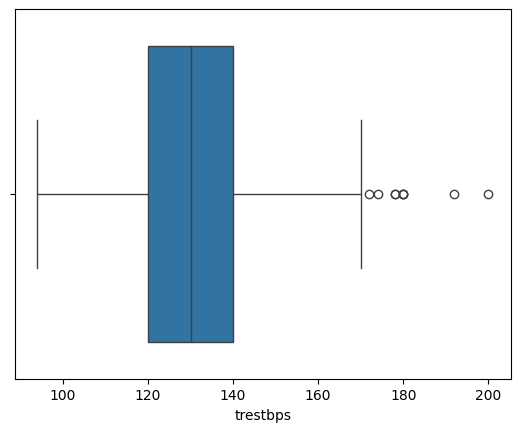

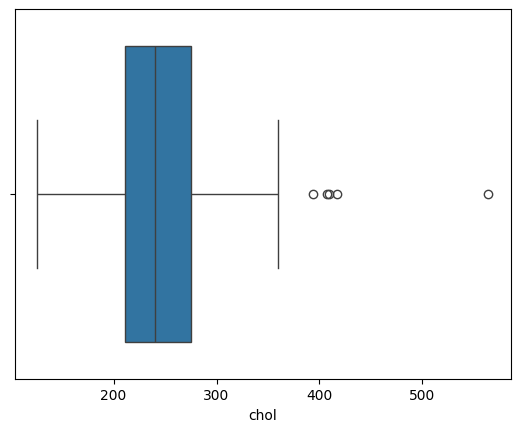

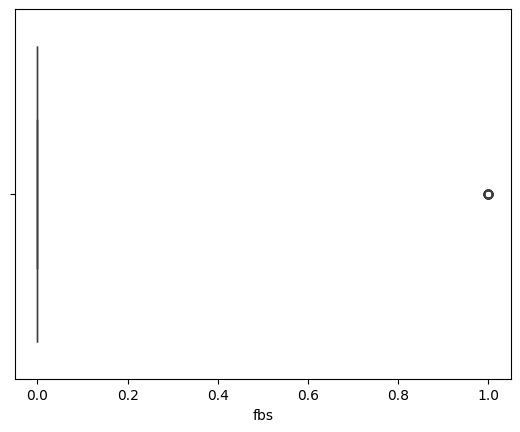

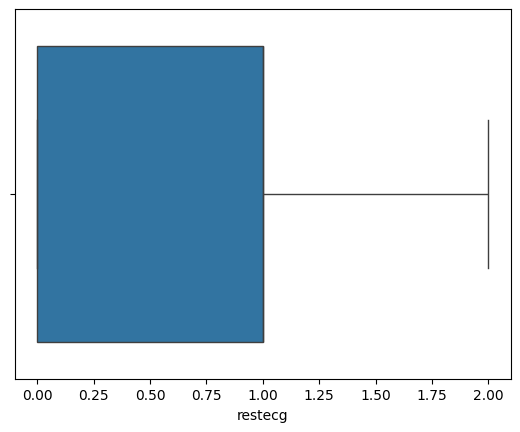

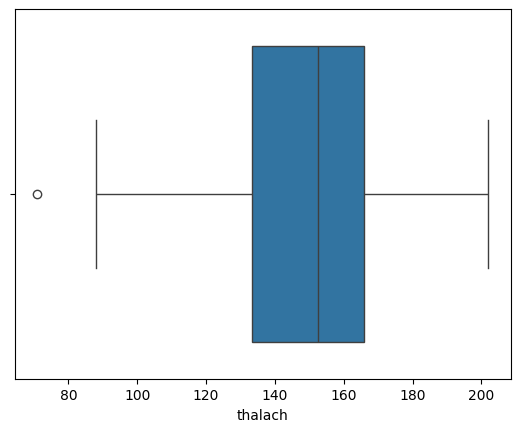

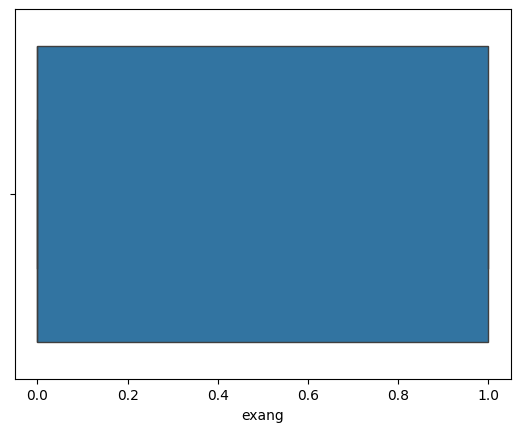

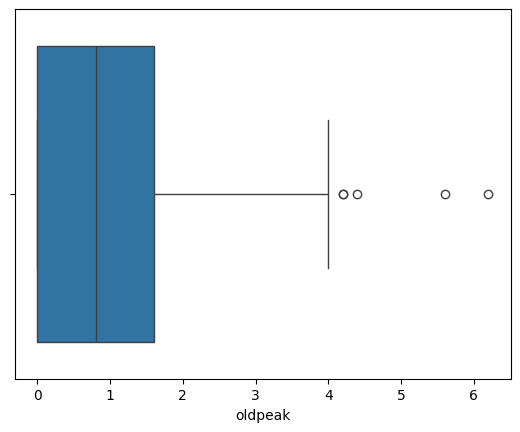

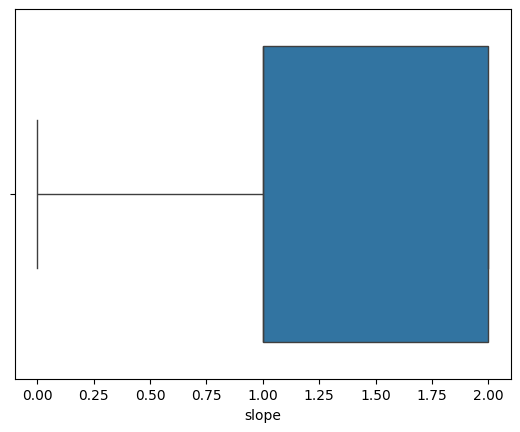

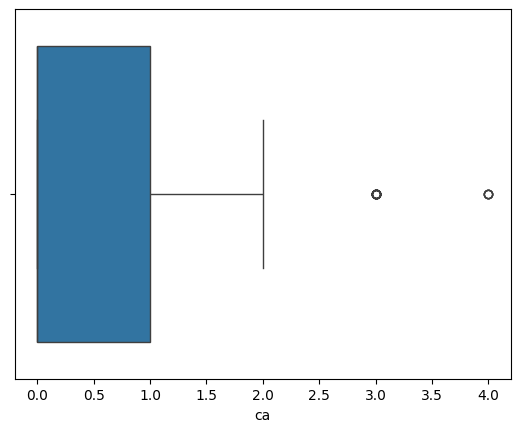

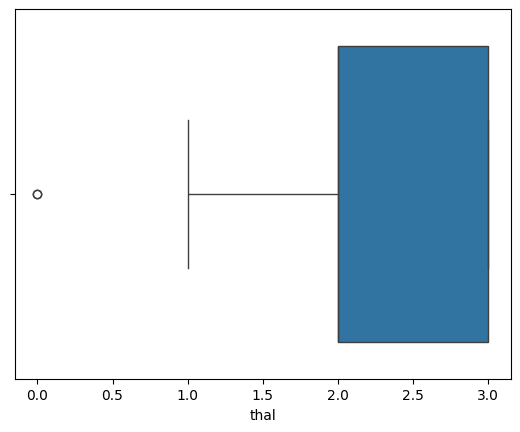

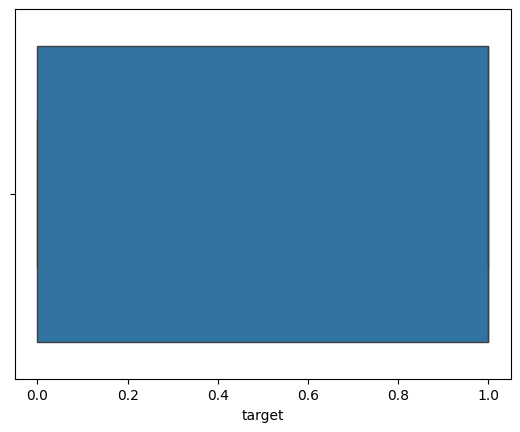

In [75]:
#Understanding the outliers through boxplot
for i in col:
    sns.boxplot(data = df,x=i)
    plt.show()

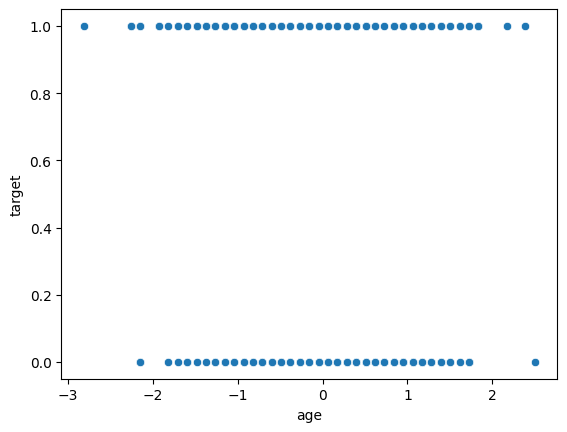

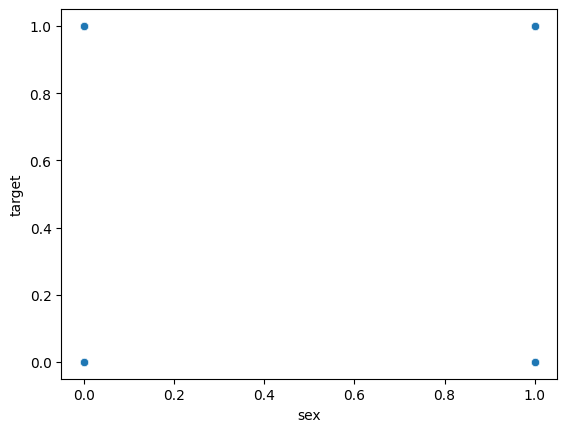

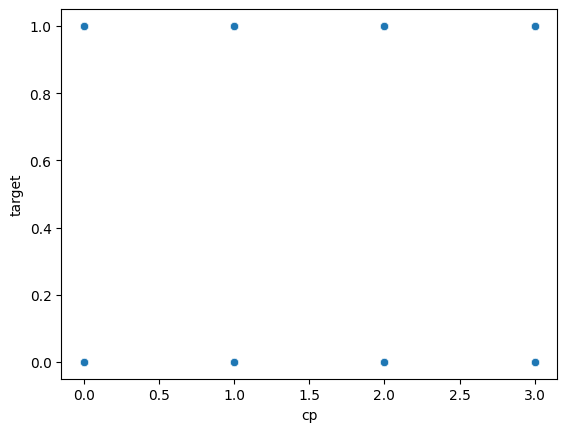

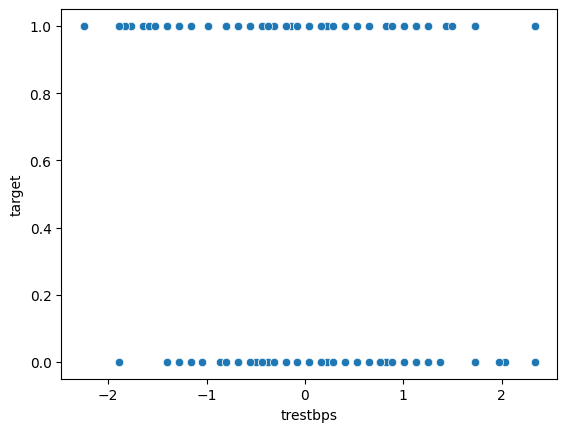

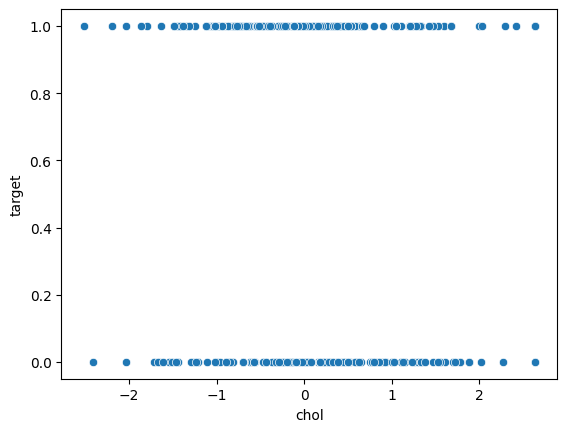

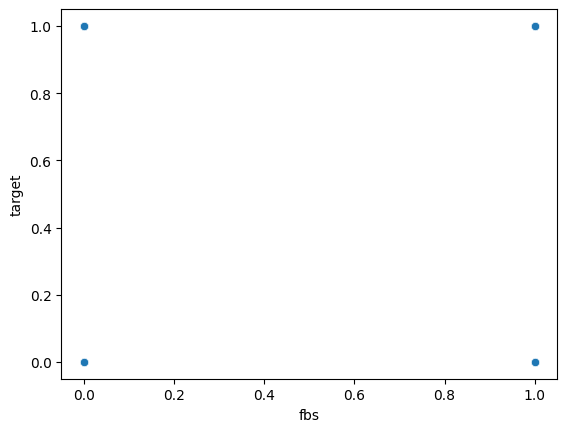

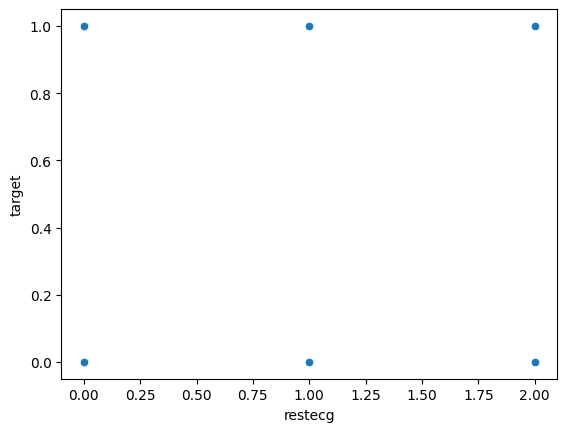

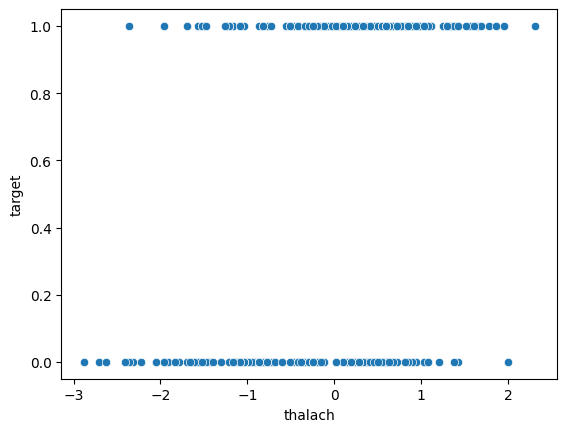

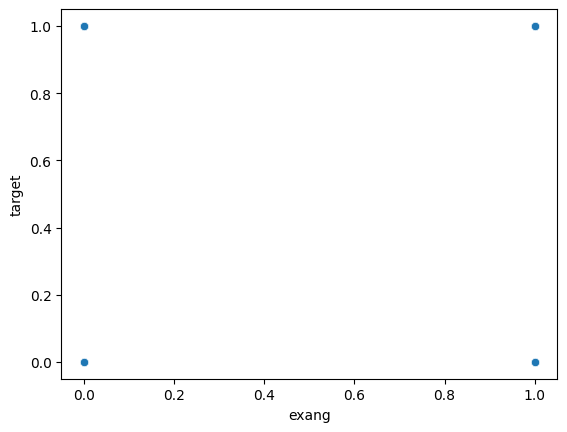

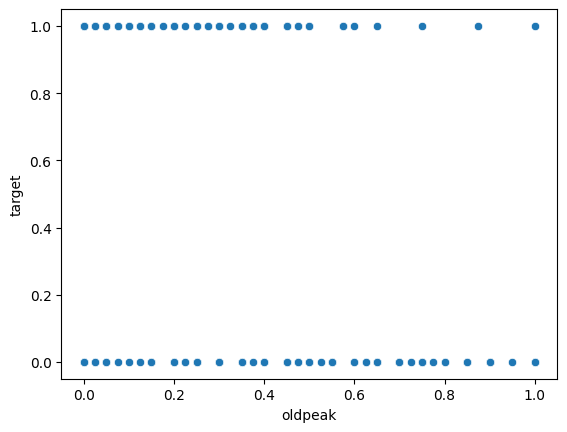

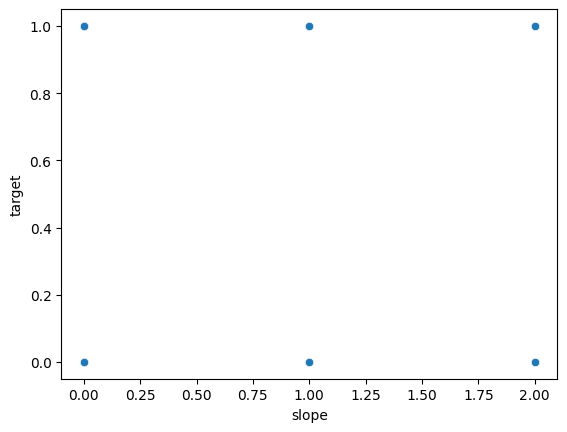

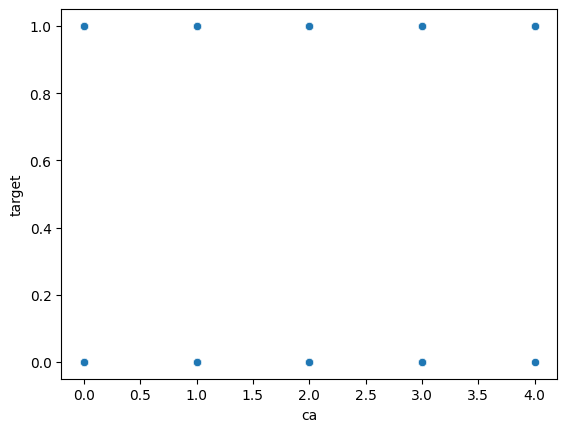

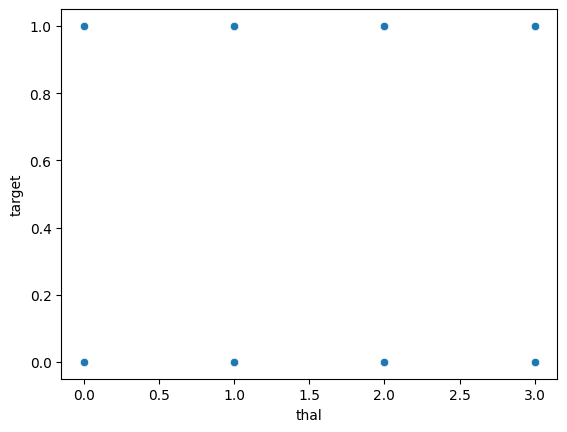

In [142]:
#understanding the relationship between the features and the target variable

for i in ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal']:
    sns.scatterplot(data = df,x=i,y='target')
    plt.show()

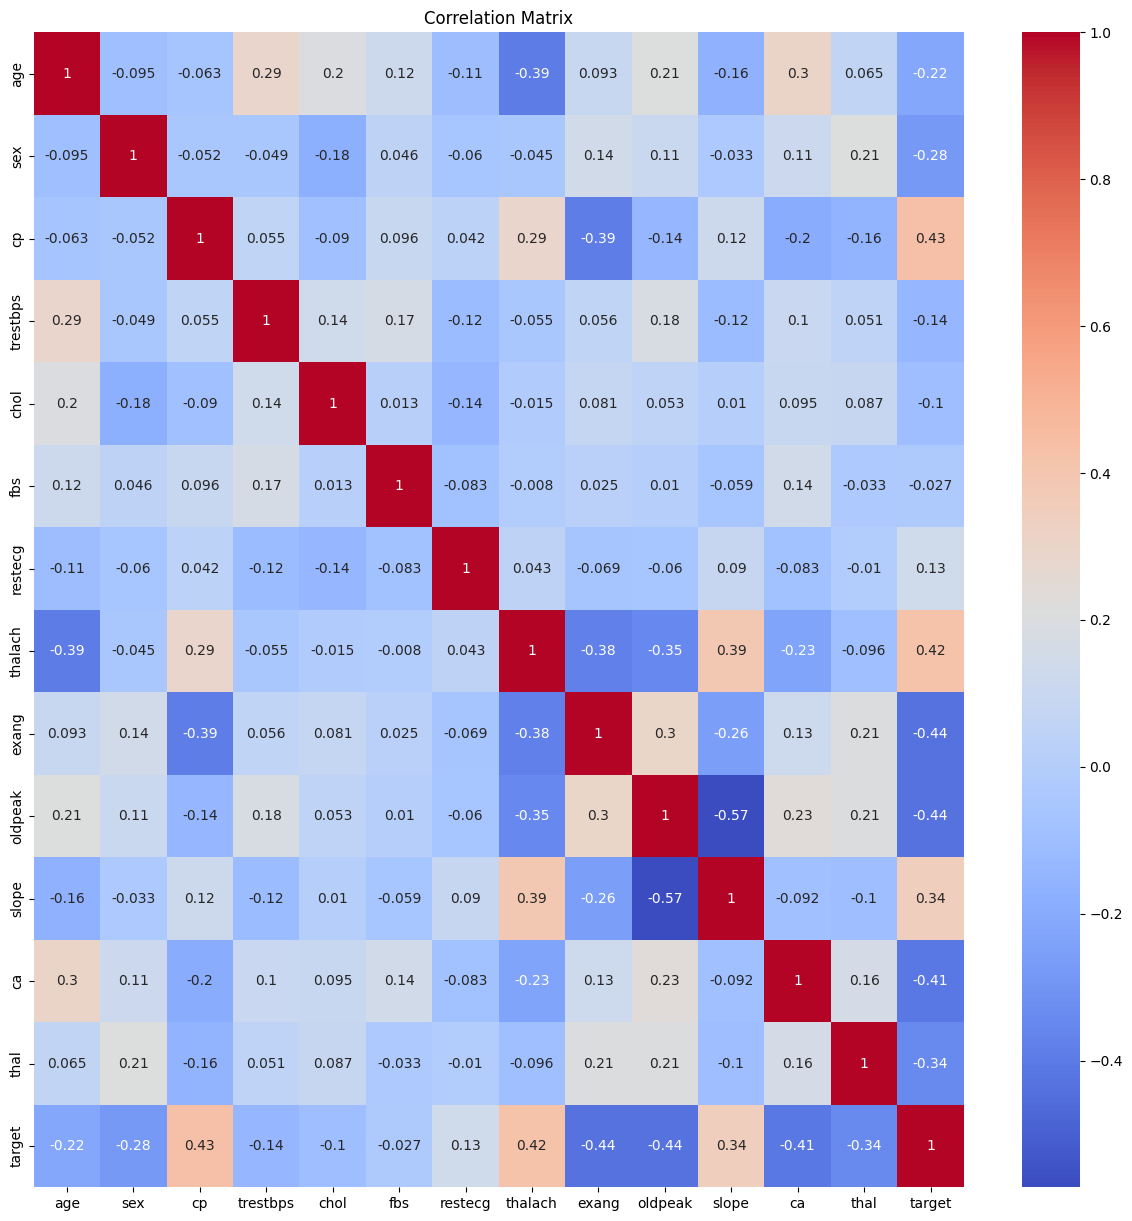

In [141]:
# Correlation Matrix
corr_matrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [87]:
#Getting the upper bound and the lower bound of the wisker
def whisker(col):
    q1=np.percentile(df[col],25)
    q3=np.percentile(df[col],75)
    iqr=q3-q1
    lower=q1-1.5*iqr
    upper=q3+1.5*iqr
    return lower,upper

In [90]:
#Fixing Outliers for these Columns
for i in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    lower,upper=whisker(i)
    df[i]=np.where(df[i]>upper,upper,df[i])
    df[i]=np.where(df[i]<lower,lower,df[i])

In [ ]:
#Checking for Outliers
for i in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    sns.boxplot(data = df,x=i)
    plt.show()

In [99]:
#Normailze Age,Oldpeak as they are not gaussian distribution using minmax scaler

scaler = MinMaxScaler()
df[['oldpeak']] = scaler.fit_transform(df[['oldpeak']])

In [100]:
#Normalize trestbps, chol, thalach as they are gaussian distribution using standard scaler

scaler = StandardScaler()
df[['thalach', 'trestbps', 'chol','age']] = scaler.fit_transform(df[['thalach', 'trestbps', 'chol','age']])

In [101]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.949794,1,3,0.828927,-0.261076,1,0,0.017027,0,0.575,0,0,1,1
1,-1.928548,1,2,-0.075902,0.097514,0,1,1.644957,0,0.875,0,0,2,1
2,-1.485726,0,1,-0.075902,-0.872787,0,0,0.984985,0,0.350,2,0,2,1
3,0.174856,1,1,-0.679121,-0.197795,0,1,1.248974,0,0.200,2,0,2,1
4,0.285561,0,0,-0.679121,2.291236,0,1,0.589003,1,0.150,2,0,2,1


In [377]:
# Spliting the data
X = df.drop([ 'trestbps', 'chol', 'fbs',
       'exang', 'oldpeak',   'target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape, X_train.shape, y_test.shape, y_train.shape

((61, 8), (241, 8), (61,), (241,))

In [378]:
# Train Logistic Regression
log_reg = LogisticRegression(C=0.01, solver='liblinear', fit_intercept=True, intercept_scaling=5, max_iter=1000)

log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_log_reg))

with open('model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

Logistic Regression Accuracy: 0.9016393442622951


In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=12)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))

with open('model2.pkl', 'wb') as f:
    pickle.dump(rf, f)

Random Forest Accuracy: 0.9016393442622951
